In [46]:
using Revise

In [47]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models

In [48]:
using Blink

In [49]:
robot = CartPole(add_contacts=false)
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 7865`, ProcessRunning), TCPSocket(RawFD(71) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(6, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(76) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 6, Nullable{Any}(true))))

In [50]:
params = MPCParams(robot)
lqrsol = LQRSolution(robot, params)
net, loss = LearningMPC.upperbound_net([4, 24, 24, 1]; regularization=0.0)
optimizer = Flux.ADAM(Flux.params(net))

net_cost = LearningMPC.LearnedCost(lqrsol, net)

net_mpc_params = MPCParams(robot)
net_mpc_params.horizon = 1
net_mpc_controller = MPCController(robot, net_mpc_params, net_cost, [lqrsol]);

full_mpc_controller = MPCController(robot, params, lqrsol, [lqrsol, net_mpc_controller]);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [51]:
sample_sink = LearningMPC.MPCSampleSink(keep_nulls=false; lqrsol=lqrsol, 
    lqr_warmstart_index=1,
    learned_warmstart_index=2)

playback_sink = LearningMPC.PlaybackSink{Float64}(mvis)

full_mpc_controller.callback = LearningMPC.multiplex!(
    sample_sink,
    playback_sink
)

live_viewer = LearningMPC.live_viewer(mvis)

dagger_controller = LearningMPC.multiplex!(
    LearningMPC.dagger_controller(
        full_mpc_controller,
        net_mpc_controller),
    live_viewer
    )

collect_into! = let x_init = nominal_state(robot), x0 = MechanismState{Float64}(robot.mechanism), sink = sample_sink
    function (data::Vector{<:LearningMPC.Sample}, σv)
        empty!(sink)
        LearningMPC.randomize!(x0, x_init, 0.5, σv)
        results = LCPSim.simulate(x0, 
            dagger_controller,
            robot.environment, params.Δt, 50, 
            params.lcp_solver;
            termination=x -> configuration(x)[2] > π/2 || configuration(x)[2] < -π/2);
        append!(data, sink.samples)
    end
end

(::#71) (generic function with 1 method)

In [52]:
library_file = "library.jld2"
dataset_file = "cartpole-upperbound.jld2"

"cartpole-upperbound.jld2"

In [53]:
if isfile(library_file)
    all_training_data, all_validation_data = jldopen(library_file) do file
        file["training"], file["testing"]
    end
else
    all_training_data = Vector{Tuple{eltype(sample_sink.samples)}}()
    all_validation_data = Vector{Tuple{eltype(sample_sink.samples)}}()
end;


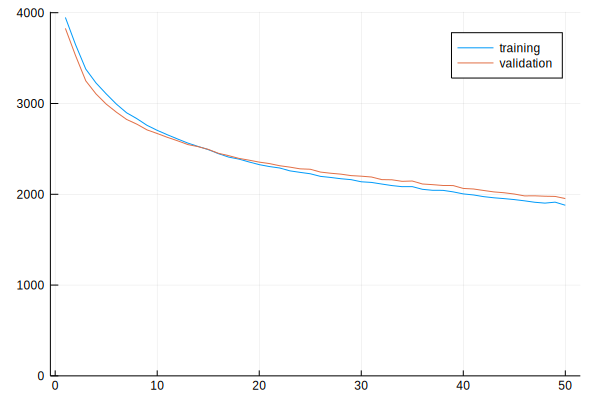

150.745025 seconds (379.09 M allocations: 21.551 GiB, 6.88% gc time)


Progress:   1%|                                         |  ETA: 9:38:45

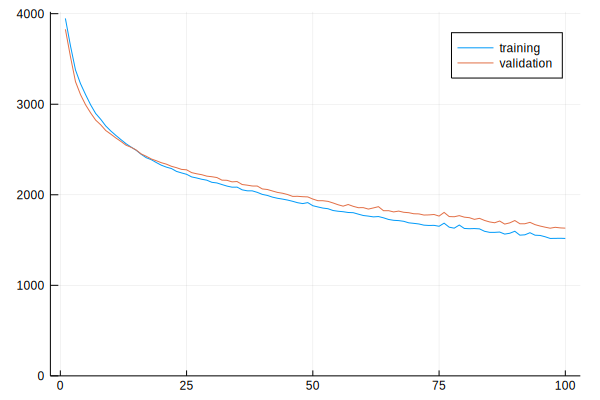

247.057944 seconds (382.63 M allocations: 21.753 GiB, 5.08% gc time)


Progress:   2%|█                                        |  ETA: 9:58:46

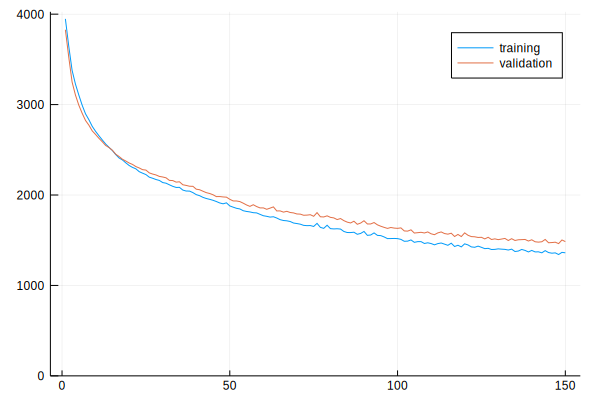

194.562935 seconds (386.18 M allocations: 21.955 GiB, 6.03% gc time)


Progress:   3%|█                                        |  ETA: 9:48:19

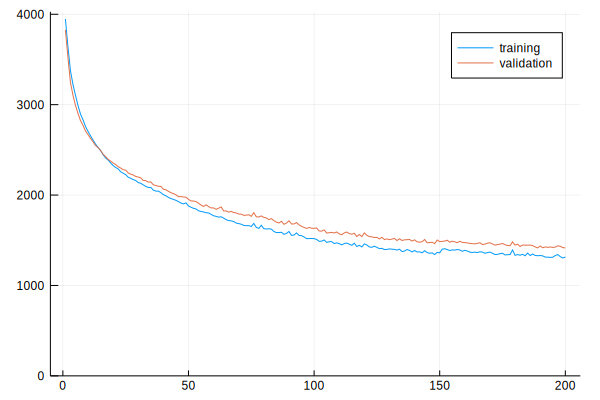

225.692431 seconds (388.36 M allocations: 22.078 GiB, 5.61% gc time)


Progress:   4%|██                                       |  ETA: 9:58:29

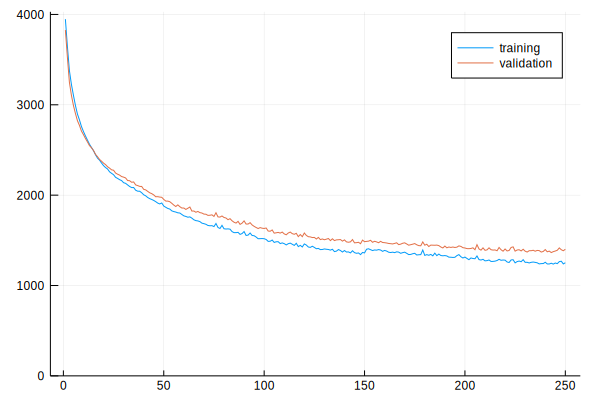

176.354016 seconds (391.91 M allocations: 22.280 GiB, 6.55% gc time)


Progress:   5%|██                                       |  ETA: 9:04:12

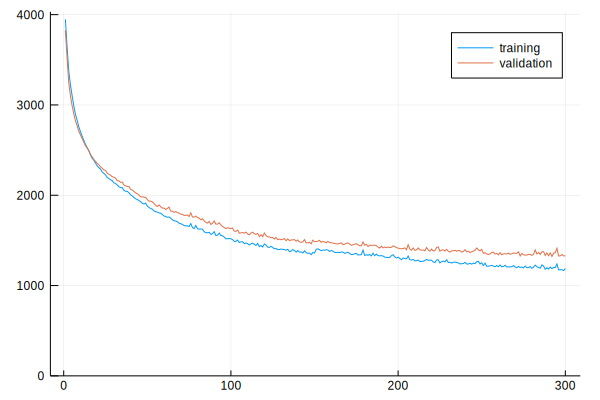

252.536884 seconds (395.47 M allocations: 22.482 GiB, 5.24% gc time)


Progress:   6%|██                                       |  ETA: 8:46:30

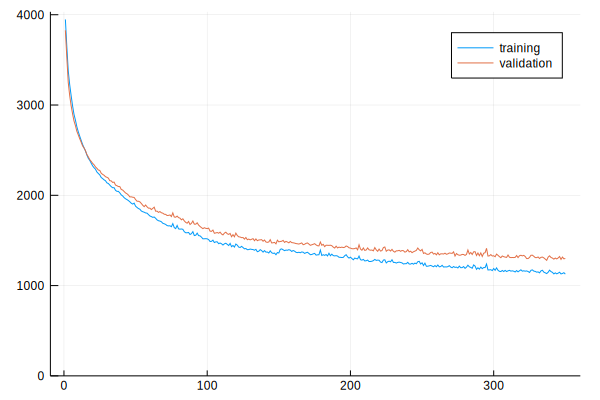

259.510332 seconds (399.02 M allocations: 22.685 GiB, 5.54% gc time)


Progress:   7%|███                                      |  ETA: 8:34:31

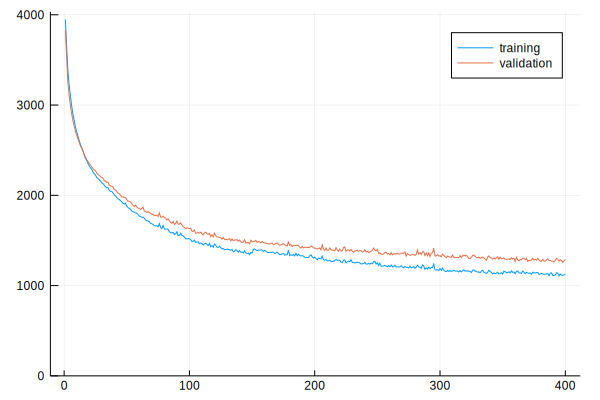

163.860381 seconds (401.55 M allocations: 22.828 GiB, 6.71% gc time)


Progress:   8%|███                                      |  ETA: 8:03:47

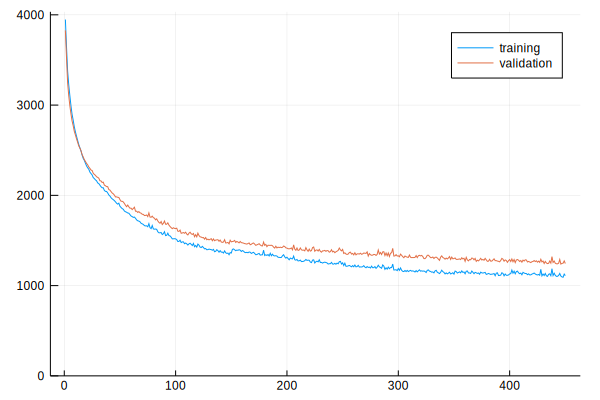

162.698443 seconds (404.12 M allocations: 22.974 GiB, 6.92% gc time)


Progress:   9%|████                                     |  ETA: 7:43:31

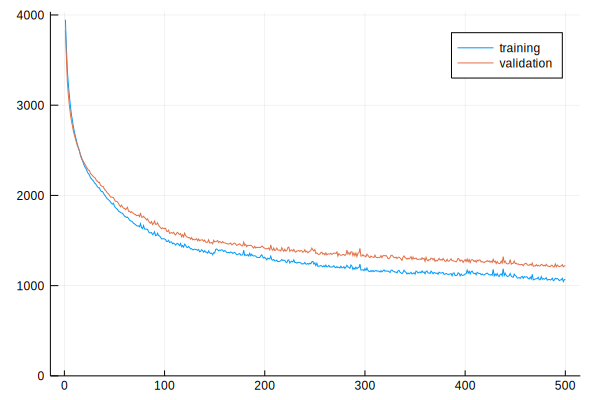

201.116772 seconds (407.67 M allocations: 23.177 GiB, 6.25% gc time)


Progress:  10%|████                                     |  ETA: 7:36:54

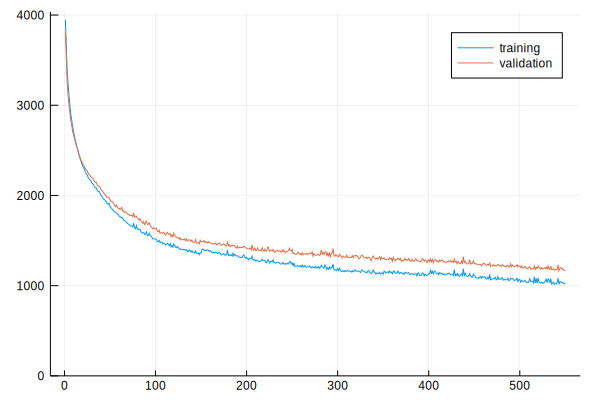

174.521147 seconds (411.23 M allocations: 23.379 GiB, 6.74% gc time)


Progress:  11%|█████                                    |  ETA: 7:36:10

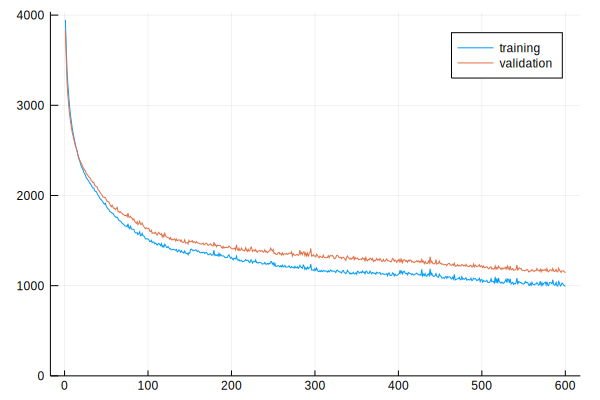

200.911175 seconds (414.78 M allocations: 23.581 GiB, 6.20% gc time)


Progress:  12%|█████                                    |  ETA: 7:38:07

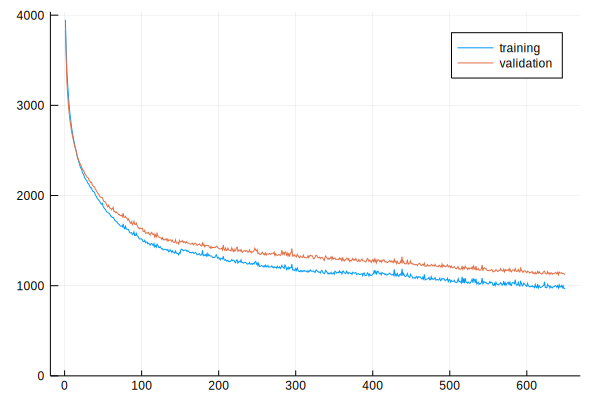

257.574393 seconds (418.34 M allocations: 23.783 GiB, 5.34% gc time)


Progress:  13%|█████                                    |  ETA: 7:33:32

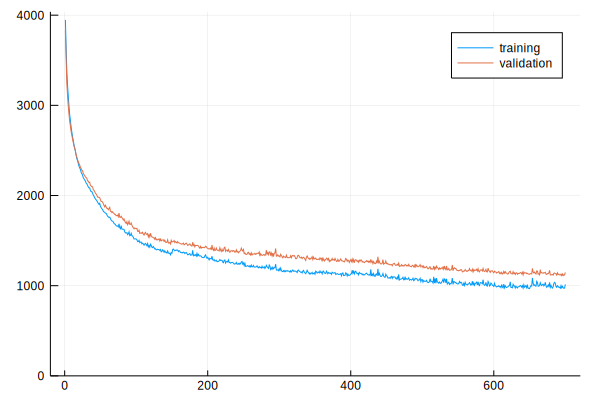

187.182420 seconds (421.22 M allocations: 23.947 GiB, 6.50% gc time)


Progress:  14%|██████                                   |  ETA: 7:42:11

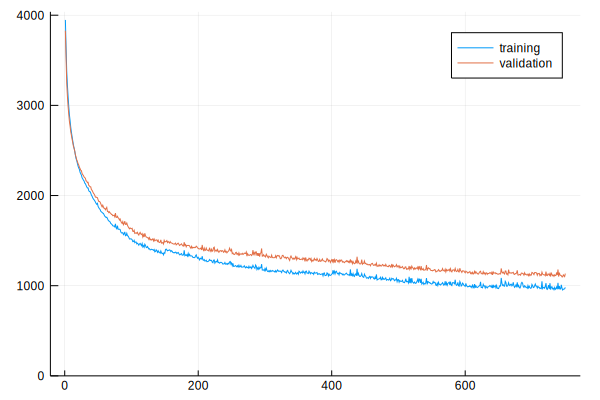

223.256865 seconds (423.67 M allocations: 24.086 GiB, 5.83% gc time)


Progress:  15%|██████                                   |  ETA: 7:31:17

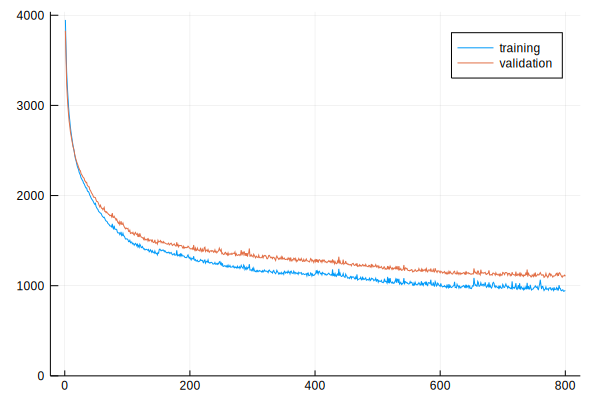

192.905422 seconds (425.98 M allocations: 24.217 GiB, 6.40% gc time)


Progress:  16%|███████                                  |  ETA: 7:17:51

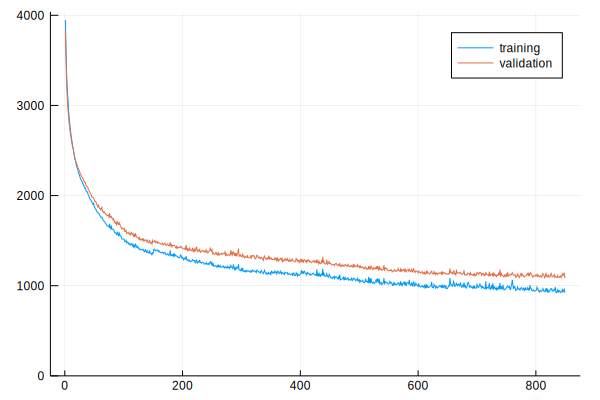

241.983234 seconds (429.54 M allocations: 24.420 GiB, 5.59% gc time)


Progress:  17%|███████                                  |  ETA: 7:22:15

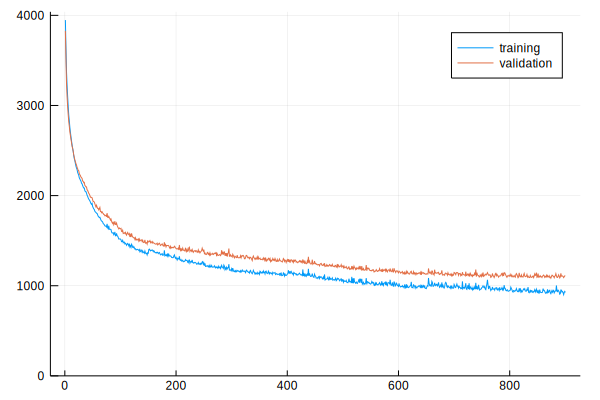

200.381589 seconds (431.32 M allocations: 24.521 GiB, 6.31% gc time)


Progress:  18%|███████                                  |  ETA: 7:10:18

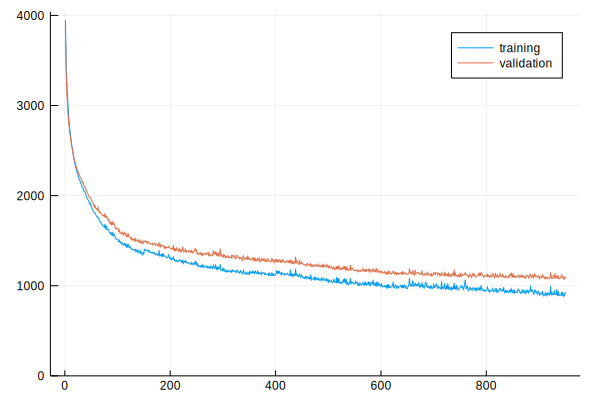

180.943257 seconds (434.87 M allocations: 24.723 GiB, 7.05% gc time)


Progress:  19%|████████                                 |  ETA: 7:01:50

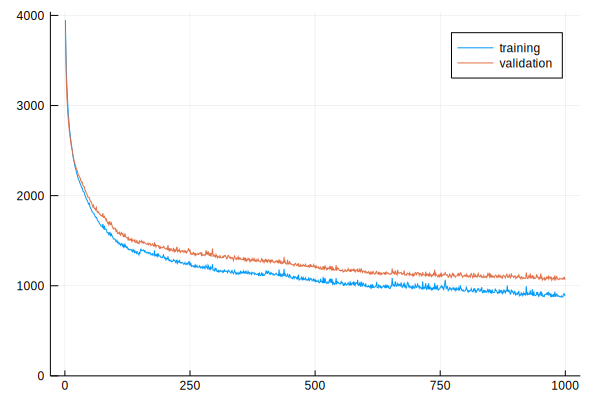

174.946224 seconds (438.43 M allocations: 24.925 GiB, 6.75% gc time)


Progress:  20%|████████                                 |  ETA: 6:50:48

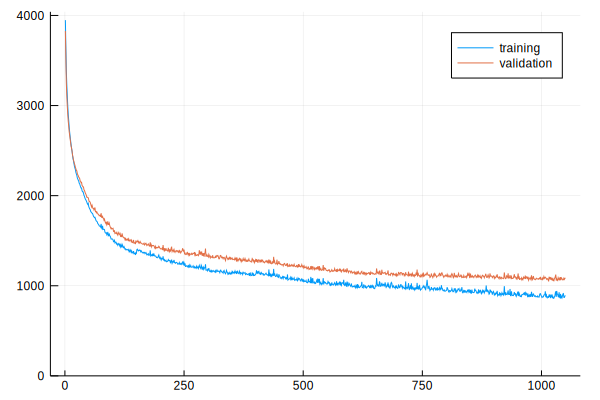

179.311662 seconds (441.98 M allocations: 25.127 GiB, 6.94% gc time)


Progress:  21%|█████████                                |  ETA: 6:40:45

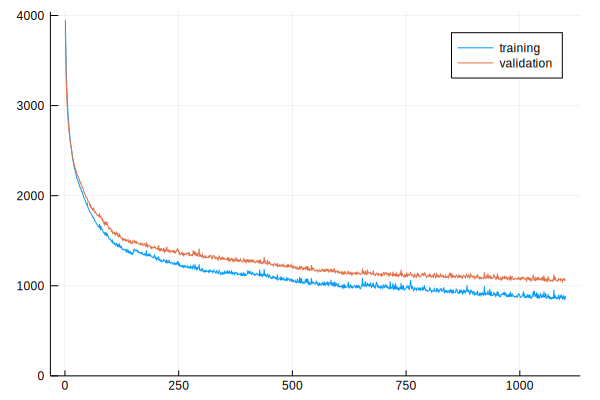

223.456608 seconds (445.54 M allocations: 25.329 GiB, 6.08% gc time)


Progress:  22%|█████████                                |  ETA: 6:35:58

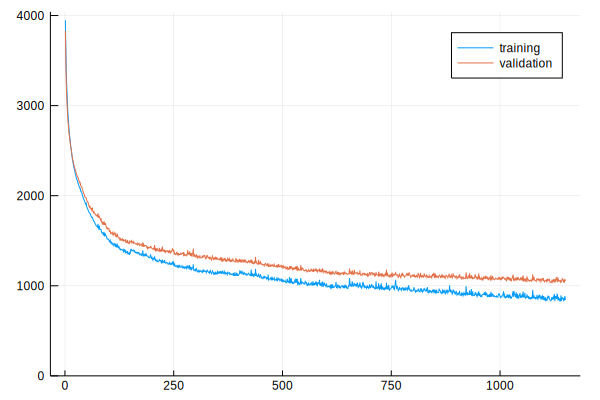

229.749292 seconds (449.09 M allocations: 25.531 GiB, 6.07% gc time)


Progress:  23%|█████████                                |  ETA: 6:32:22

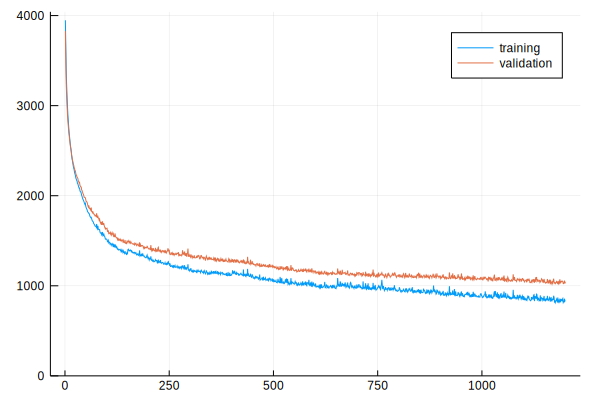

284.939012 seconds (452.65 M allocations: 25.733 GiB, 5.28% gc time)


Progress:  24%|██████████                               |  ETA: 6:30:55

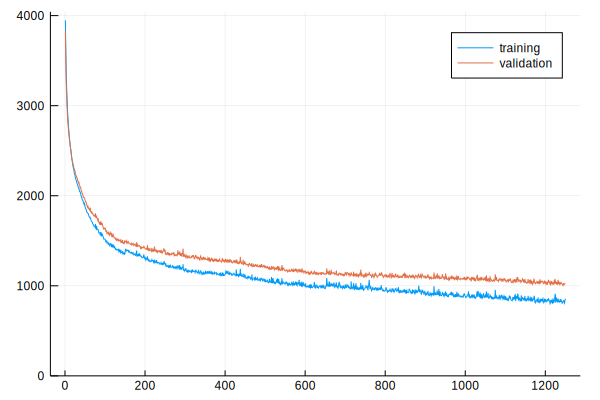

243.143472 seconds (456.20 M allocations: 25.935 GiB, 6.01% gc time)


Progress:  25%|██████████                               |  ETA: 6:24:52

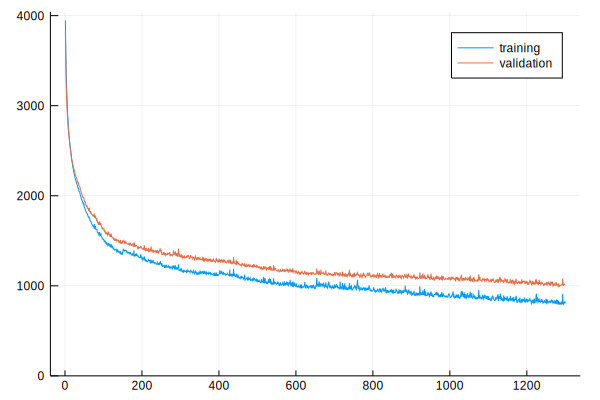

245.281848 seconds (459.76 M allocations: 26.137 GiB, 5.80% gc time)


Progress:  26%|███████████                              |  ETA: 6:23:33

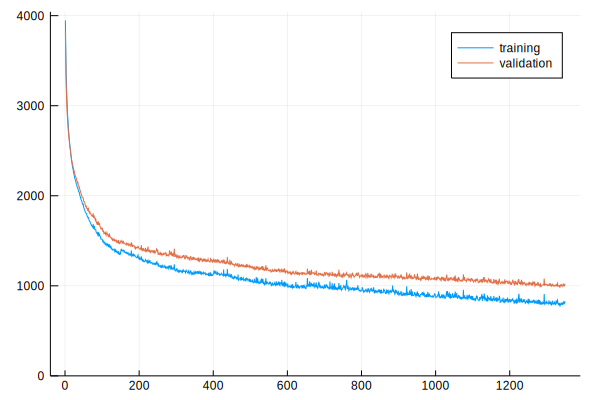

200.754050 seconds (463.31 M allocations: 26.340 GiB, 6.58% gc time)


Progress:  27%|███████████                              |  ETA: 6:17:07

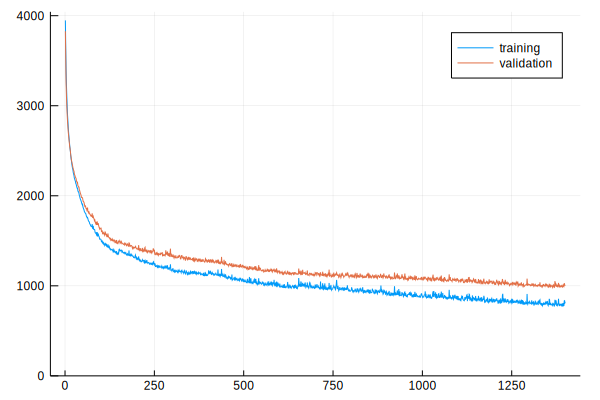

208.067718 seconds (466.87 M allocations: 26.542 GiB, 6.31% gc time)


Progress:  28%|███████████                              |  ETA: 6:15:27

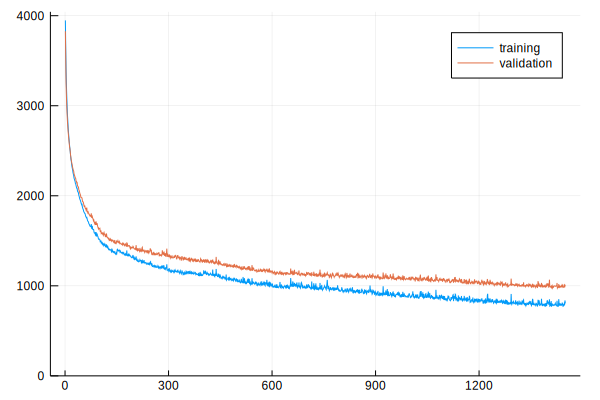

255.191594 seconds (470.42 M allocations: 26.744 GiB, 5.51% gc time)


Progress:  29%|████████████                             |  ETA: 6:11:43

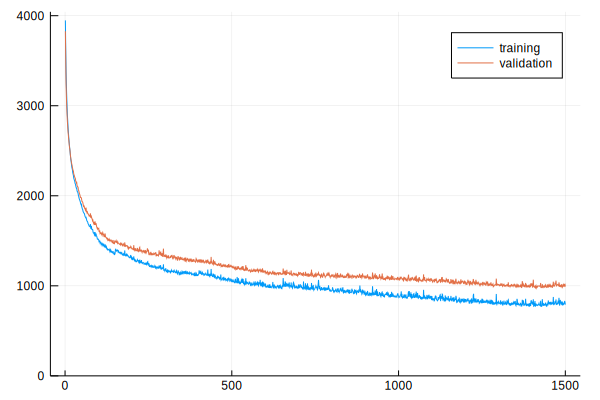

218.038179 seconds (473.98 M allocations: 26.946 GiB, 6.49% gc time)


Progress:  30%|████████████                             |  ETA: 6:08:39

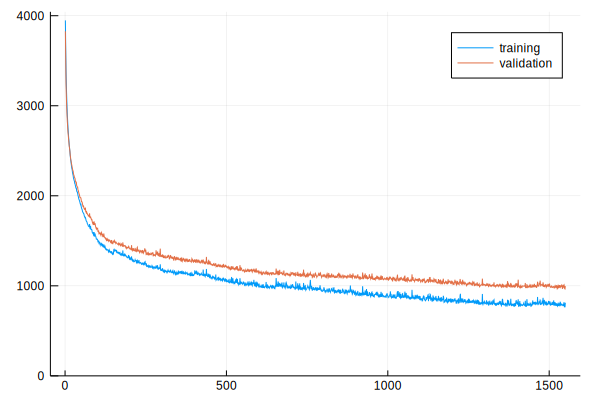

348.336412 seconds (477.53 M allocations: 27.148 GiB, 5.10% gc time)


Progress:  31%|█████████████                            |  ETA: 6:06:20

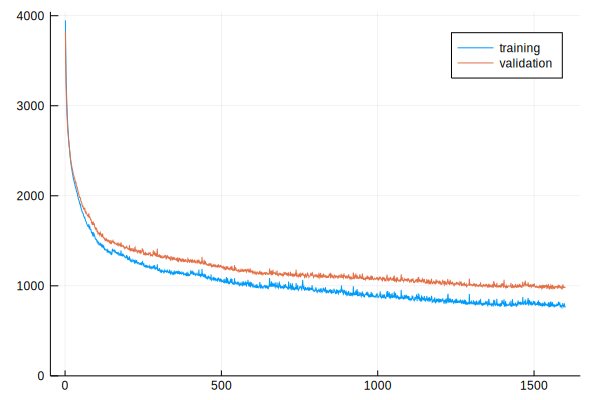

266.169471 seconds (481.09 M allocations: 27.350 GiB, 5.65% gc time)


Progress:  32%|█████████████                            |  ETA: 6:03:27

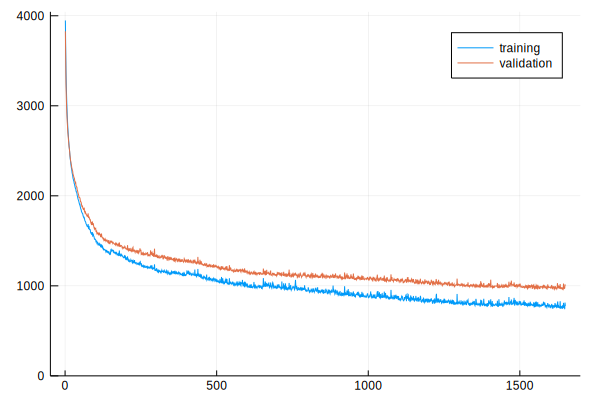

293.066274 seconds (484.64 M allocations: 27.552 GiB, 5.74% gc time)


Progress:  33%|██████████████                           |  ETA: 5:59:06

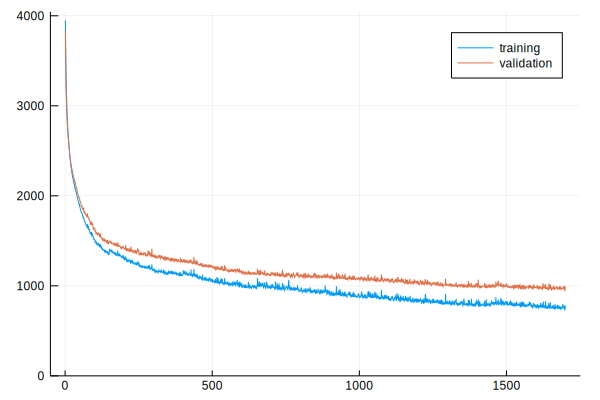

199.399070 seconds (488.20 M allocations: 27.754 GiB, 6.81% gc time)


Progress:  34%|██████████████                           |  ETA: 5:51:14

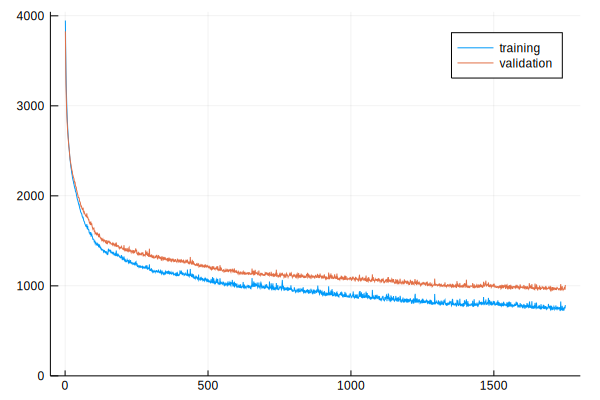

268.078156 seconds (491.75 M allocations: 27.956 GiB, 5.82% gc time)


Progress:  35%|██████████████                           |  ETA: 5:51:07

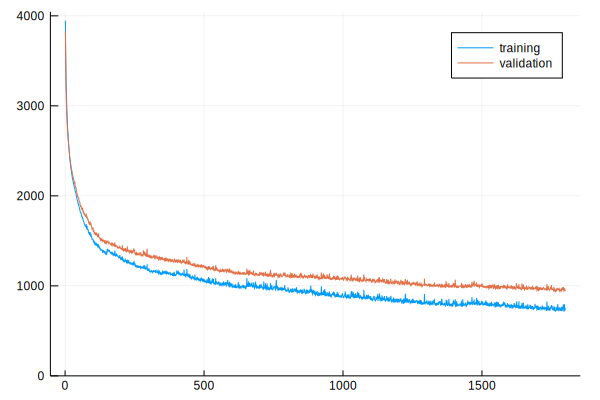

211.951274 seconds (495.31 M allocations: 28.158 GiB, 6.72% gc time)


Progress:  36%|███████████████                          |  ETA: 5:44:17

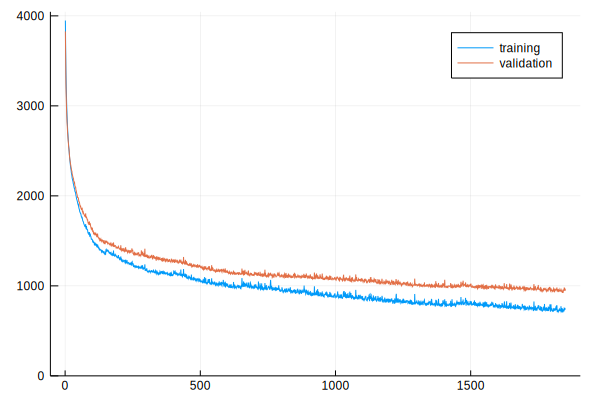

205.436916 seconds (498.86 M allocations: 28.361 GiB, 6.53% gc time)


Progress:  37%|███████████████                          |  ETA: 5:37:07

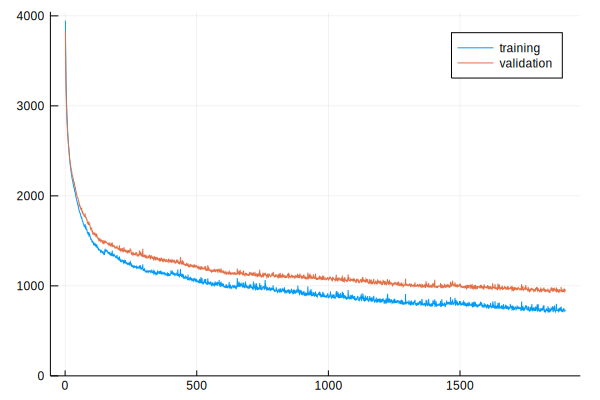

209.458753 seconds (502.42 M allocations: 28.563 GiB, 6.76% gc time)


Progress:  38%|████████████████                         |  ETA: 5:33:38

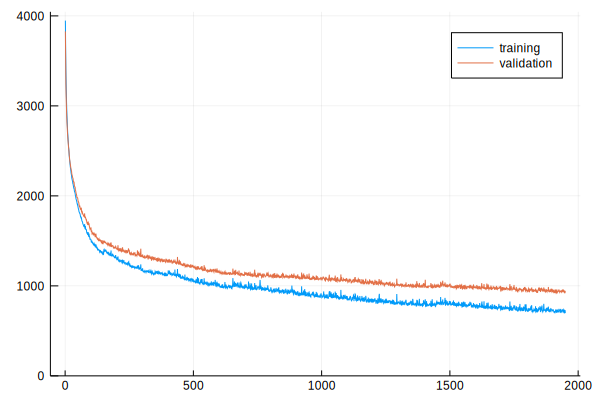

238.146807 seconds (505.97 M allocations: 28.765 GiB, 6.03% gc time)


Progress:  39%|████████████████                         |  ETA: 5:27:15

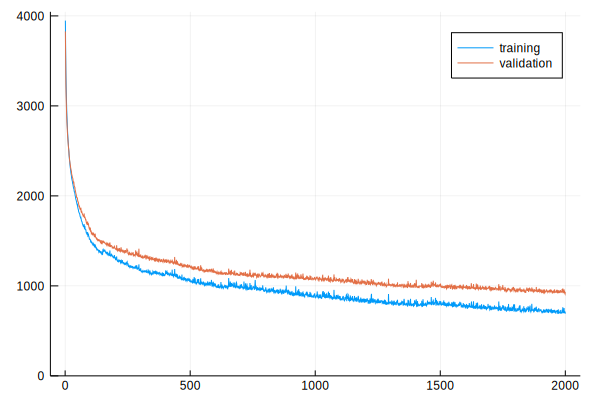

209.039573 seconds (509.53 M allocations: 28.967 GiB, 6.60% gc time)


Progress:  40%|████████████████                         |  ETA: 5:22:09

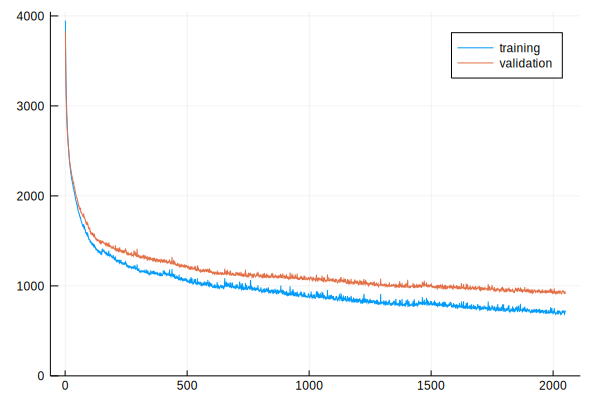

281.319295 seconds (513.08 M allocations: 29.169 GiB, 5.64% gc time)


Progress:  41%|█████████████████                        |  ETA: 5:19:00

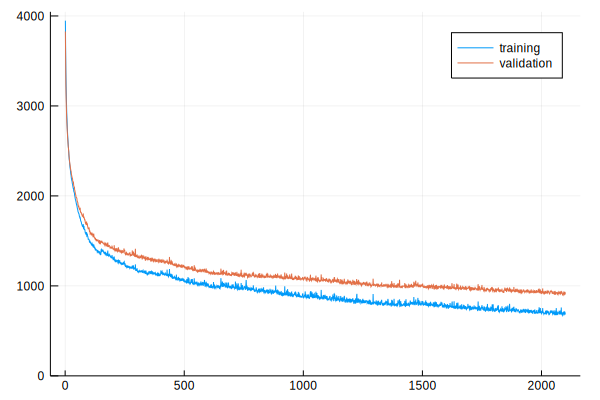

302.244632 seconds (516.64 M allocations: 29.371 GiB, 5.50% gc time)


Progress:  42%|█████████████████                        |  ETA: 5:15:04

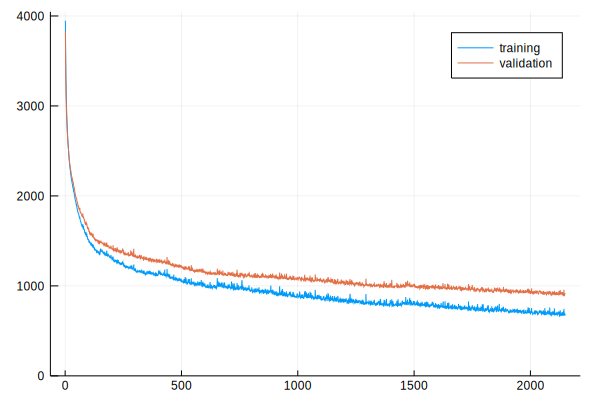

218.521619 seconds (520.19 M allocations: 29.573 GiB, 6.67% gc time)


Progress:  43%|██████████████████                       |  ETA: 5:08:28

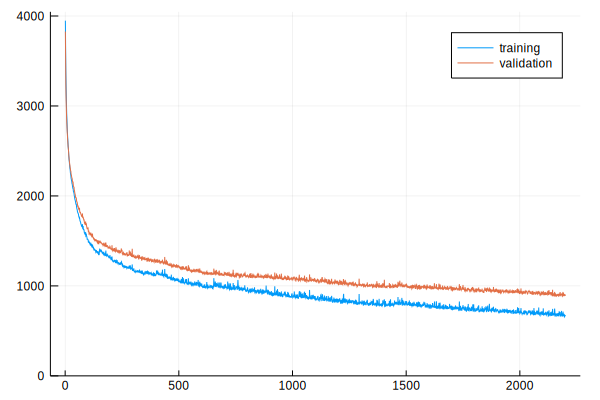

276.561906 seconds (523.75 M allocations: 29.775 GiB, 5.95% gc time)


Progress:  44%|██████████████████                       |  ETA: 5:05:03

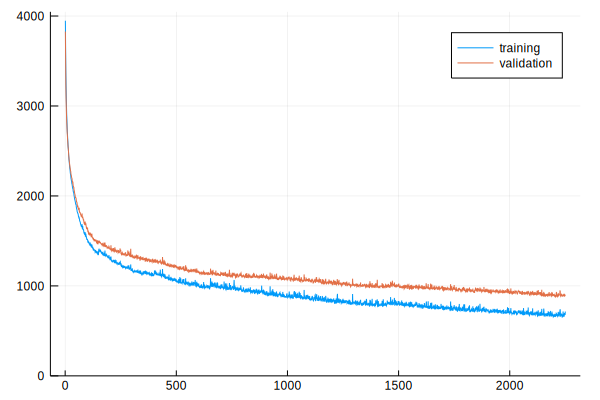

219.587116 seconds (527.30 M allocations: 29.977 GiB, 6.77% gc time)


Progress:  45%|██████████████████                       |  ETA: 4:59:42

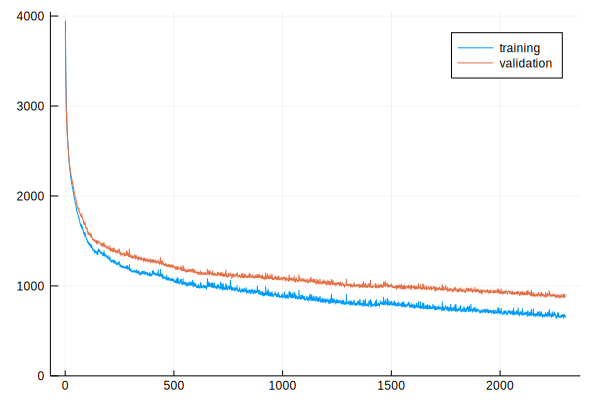

248.343079 seconds (530.86 M allocations: 30.179 GiB, 6.35% gc time)


Progress:  46%|███████████████████                      |  ETA: 4:53:36

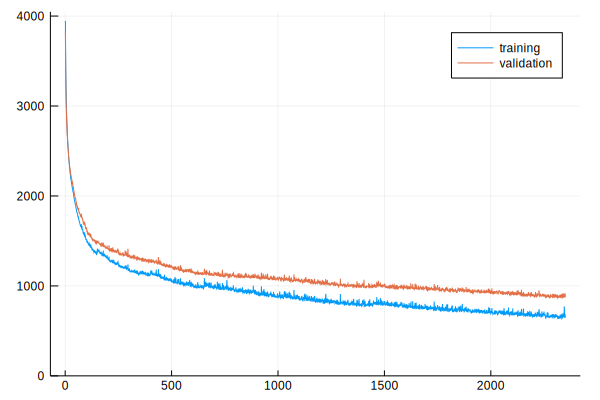

326.505360 seconds (534.41 M allocations: 30.382 GiB, 5.41% gc time)


Progress:  47%|███████████████████                      |  ETA: 4:49:43

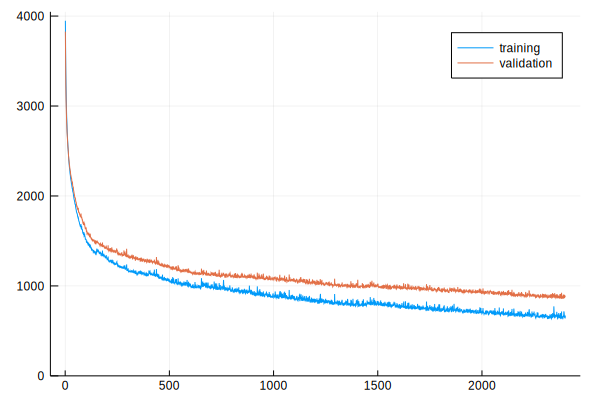

220.902384 seconds (536.94 M allocations: 30.525 GiB, 6.69% gc time)


Progress:  48%|████████████████████                     |  ETA: 4:43:32

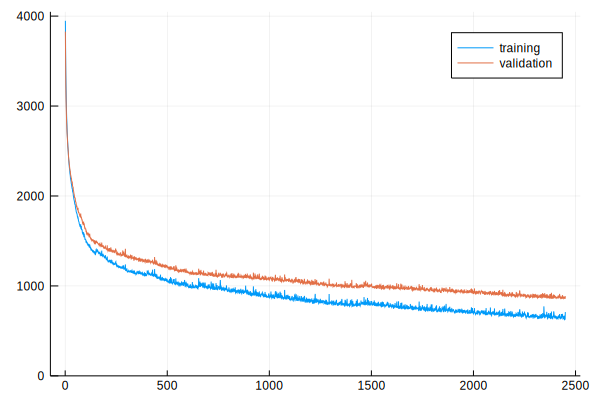

262.599309 seconds (540.49 M allocations: 30.727 GiB, 6.15% gc time)


Progress:  49%|████████████████████                     |  ETA: 4:38:23

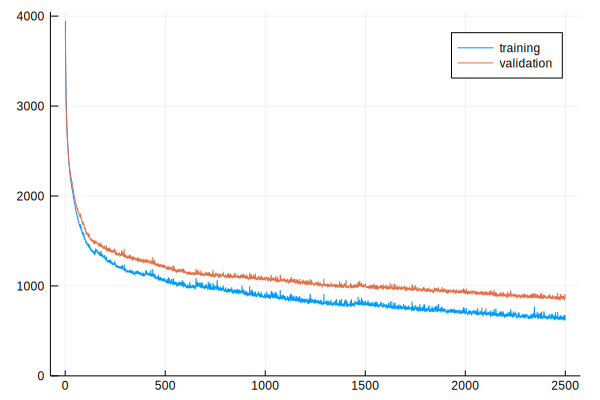

231.521055 seconds (544.05 M allocations: 30.930 GiB, 6.39% gc time)


Progress:  50%|████████████████████                     |  ETA: 4:32:13

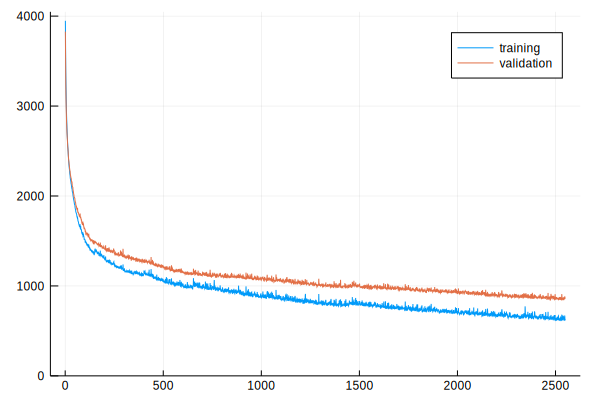

380.731399 seconds (547.60 M allocations: 31.132 GiB, 5.30% gc time)


Progress:  51%|█████████████████████                    |  ETA: 4:28:31

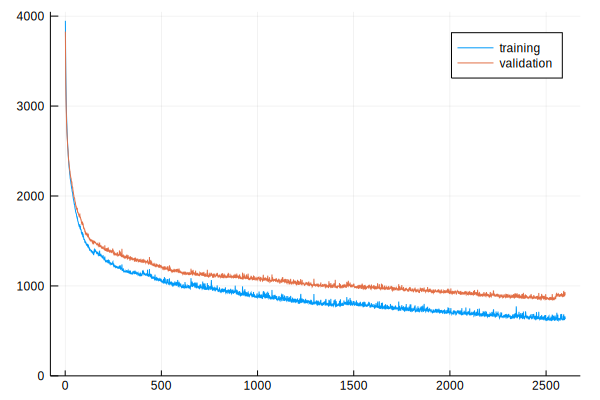

344.233703 seconds (551.12 M allocations: 31.331 GiB, 5.34% gc time)


Progress:  52%|█████████████████████                    |  ETA: 4:26:03

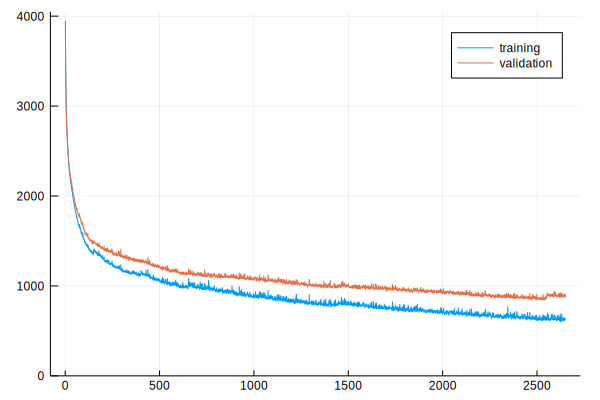

229.919759 seconds (554.67 M allocations: 31.534 GiB, 6.84% gc time)


Progress:  53%|██████████████████████                   |  ETA: 4:20:20

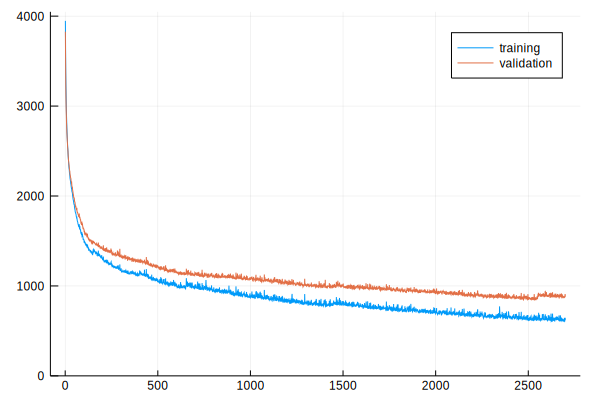

242.640591 seconds (558.23 M allocations: 31.736 GiB, 6.55% gc time)


Progress:  54%|██████████████████████                   |  ETA: 4:16:20

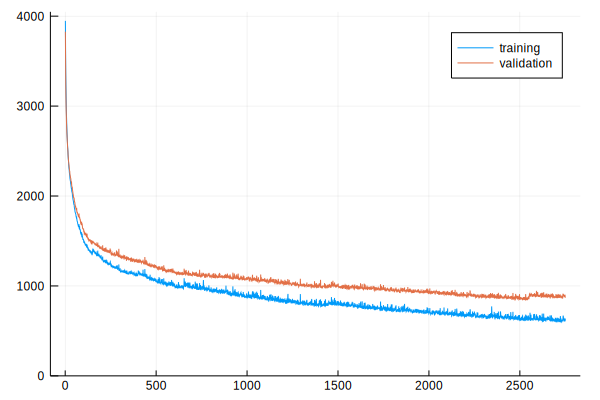

318.300833 seconds (561.78 M allocations: 31.938 GiB, 5.55% gc time)


Progress:  55%|███████████████████████                  |  ETA: 4:11:14

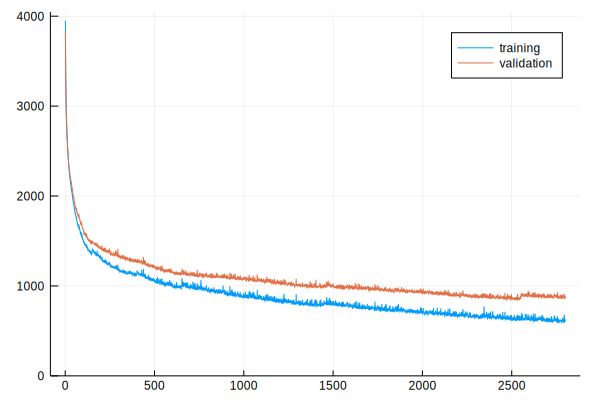

324.560956 seconds (565.34 M allocations: 32.140 GiB, 5.28% gc time)


Progress:  56%|███████████████████████                  |  ETA: 4:06:12

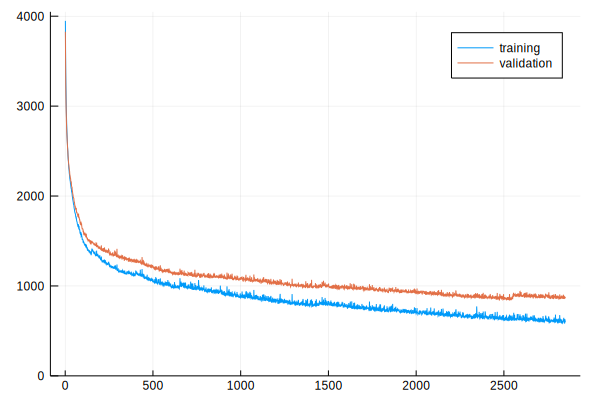

330.633600 seconds (568.89 M allocations: 32.342 GiB, 5.64% gc time)


Progress:  57%|███████████████████████                  |  ETA: 4:01:38

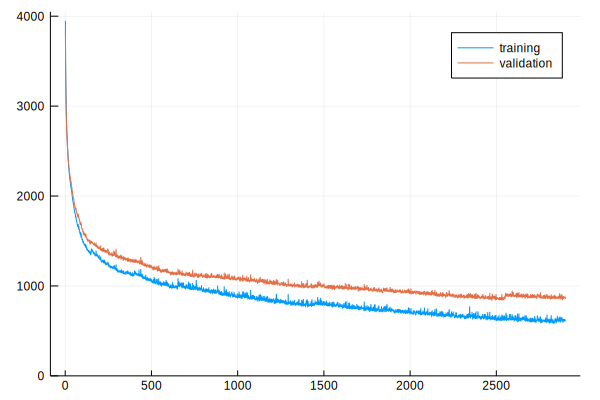

286.732849 seconds (572.23 M allocations: 32.532 GiB, 5.99% gc time)


Progress:  58%|████████████████████████                 |  ETA: 3:57:38

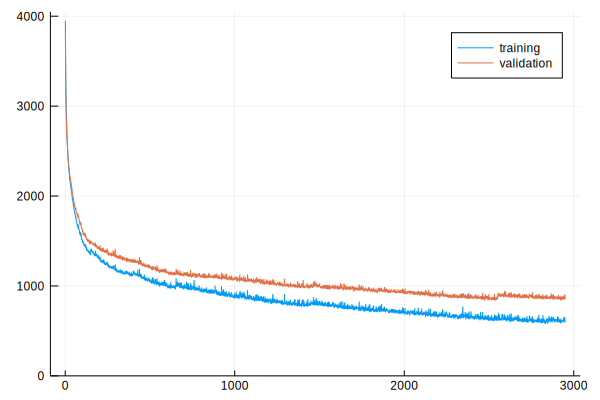

237.608863 seconds (575.79 M allocations: 32.734 GiB, 6.90% gc time)


Progress:  59%|████████████████████████                 |  ETA: 3:51:22

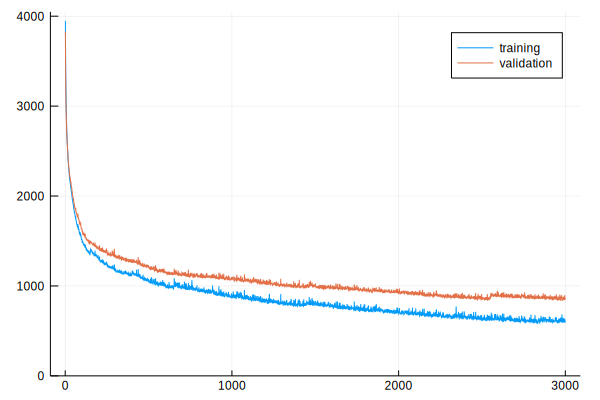

297.245498 seconds (579.34 M allocations: 32.936 GiB, 5.87% gc time)


Progress:  60%|█████████████████████████                |  ETA: 3:45:55

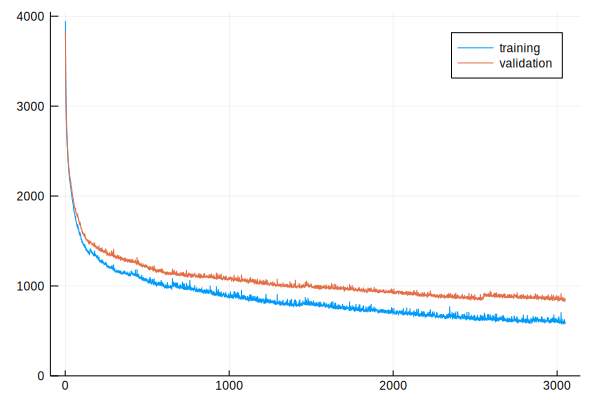

276.543391 seconds (582.90 M allocations: 33.138 GiB, 6.00% gc time)


Progress:  61%|█████████████████████████                |  ETA: 3:40:48

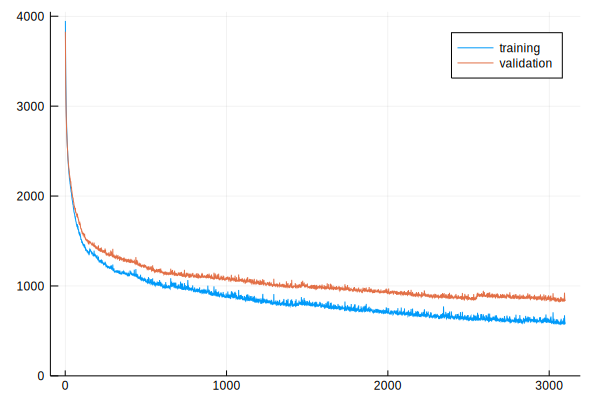

239.742284 seconds (586.45 M allocations: 33.340 GiB, 6.80% gc time)


Progress:  62%|█████████████████████████                |  ETA: 3:35:11

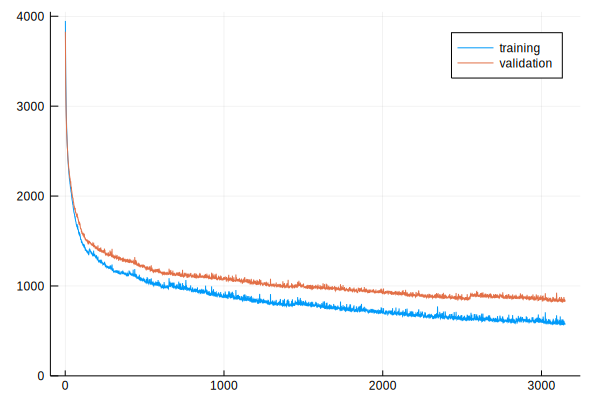

296.044165 seconds (590.01 M allocations: 33.542 GiB, 6.14% gc time)


Progress:  63%|██████████████████████████               |  ETA: 3:29:35

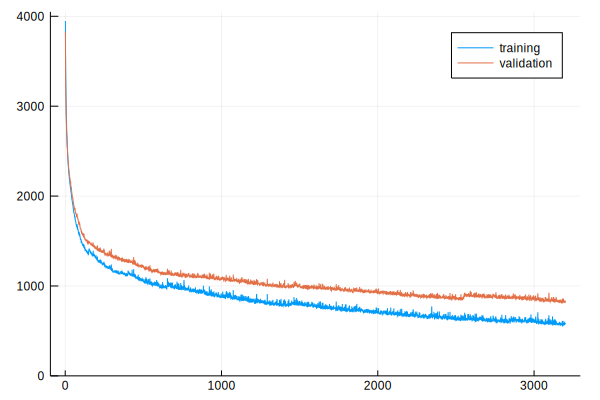

240.204241 seconds (593.56 M allocations: 33.744 GiB, 6.80% gc time)


Progress:  64%|██████████████████████████               |  ETA: 3:23:26

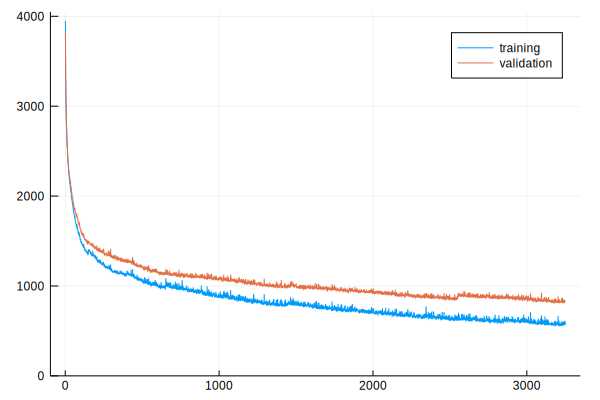

347.814397 seconds (597.12 M allocations: 33.946 GiB, 5.53% gc time)


Progress:  65%|███████████████████████████              |  ETA: 3:18:17

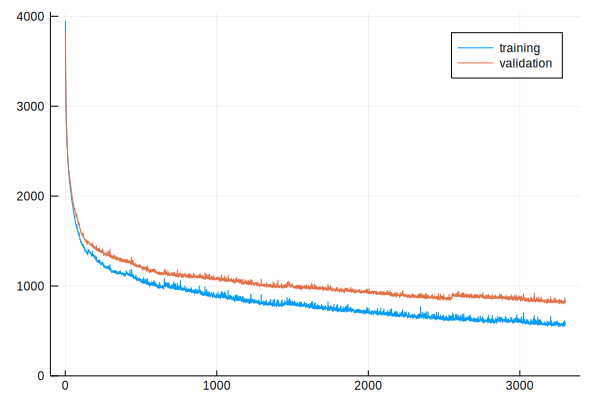

317.029214 seconds (600.67 M allocations: 34.149 GiB, 6.01% gc time)


Progress:  66%|███████████████████████████              |  ETA: 3:12:50

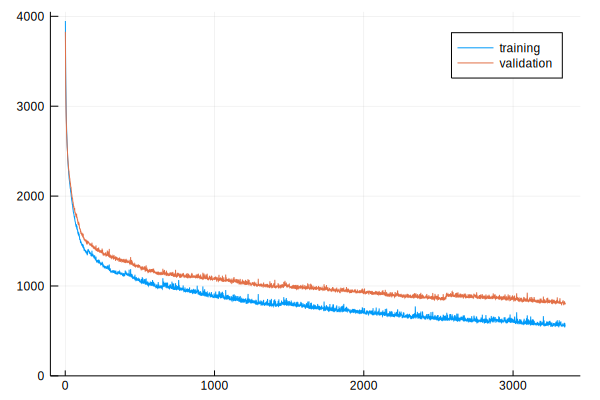

258.777834 seconds (604.23 M allocations: 34.351 GiB, 6.51% gc time)


Progress:  67%|███████████████████████████              |  ETA: 3:07:10

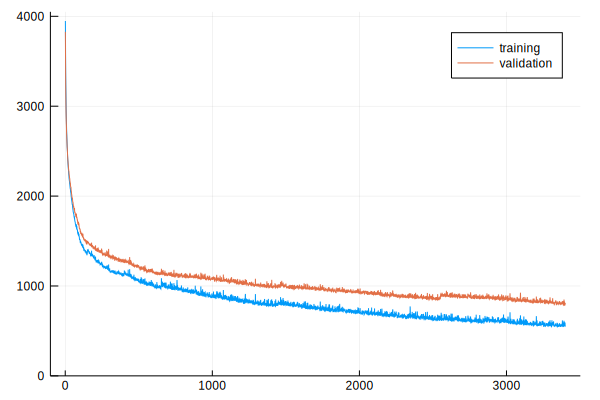

345.564616 seconds (607.78 M allocations: 34.553 GiB, 5.74% gc time)


Progress:  68%|████████████████████████████             |  ETA: 3:02:20

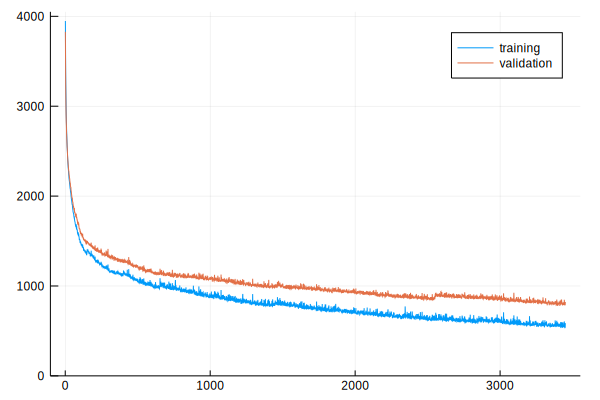

359.614311 seconds (611.34 M allocations: 34.755 GiB, 5.57% gc time)


Progress:  69%|████████████████████████████             |  ETA: 2:58:23

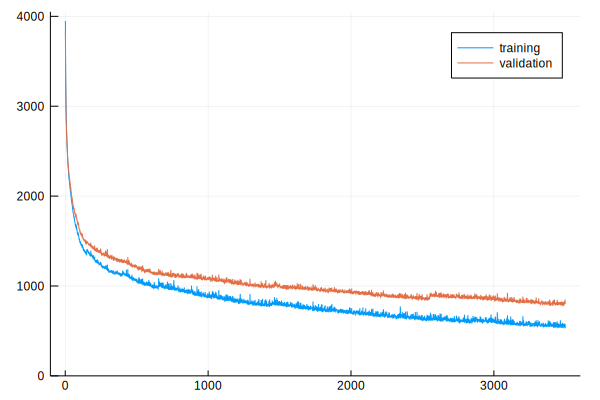

289.651818 seconds (614.89 M allocations: 34.957 GiB, 6.24% gc time)


Progress:  70%|█████████████████████████████            |  ETA: 2:53:19

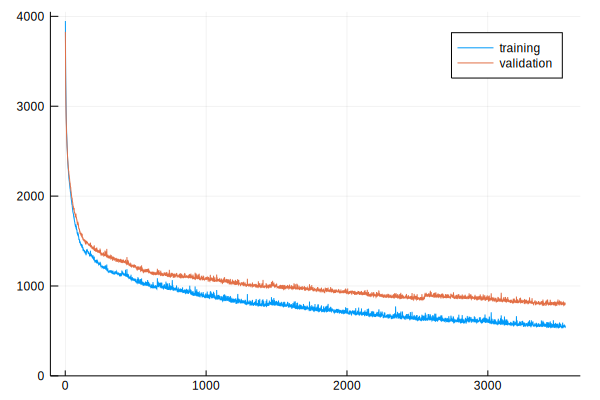

303.804526 seconds (618.45 M allocations: 35.159 GiB, 5.79% gc time)


Progress:  71%|█████████████████████████████            |  ETA: 2:47:57

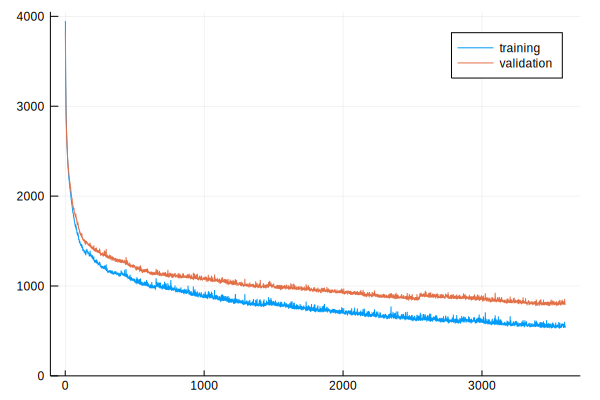

321.646512 seconds (622.00 M allocations: 35.361 GiB, 5.97% gc time)


Progress:  72%|██████████████████████████████           |  ETA: 2:42:45

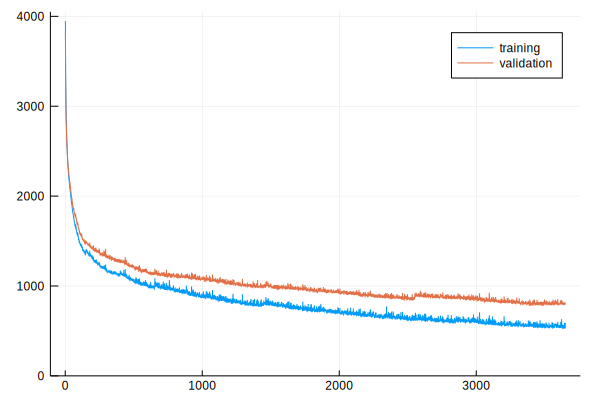

255.387106 seconds (625.56 M allocations: 35.563 GiB, 6.82% gc time)


Progress:  73%|██████████████████████████████           |  ETA: 2:36:39

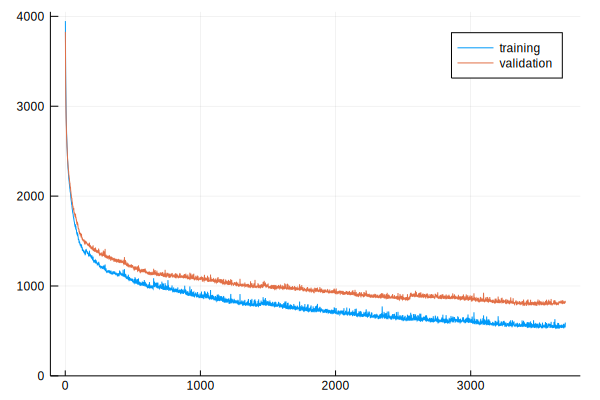

305.111902 seconds (627.91 M allocations: 35.697 GiB, 6.08% gc time)


Progress:  74%|██████████████████████████████           |  ETA: 2:31:09

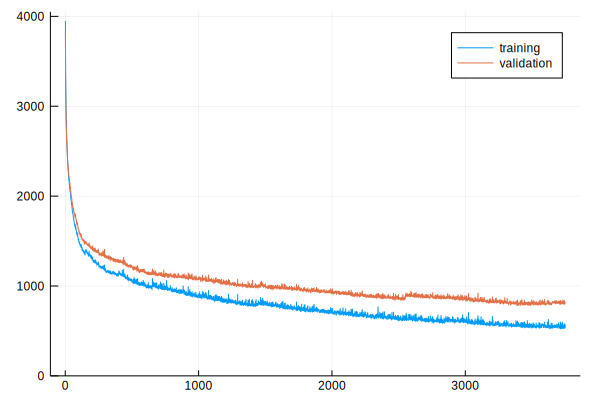

272.779413 seconds (631.46 M allocations: 35.899 GiB, 6.58% gc time)


Progress:  75%|███████████████████████████████          |  ETA: 2:25:44

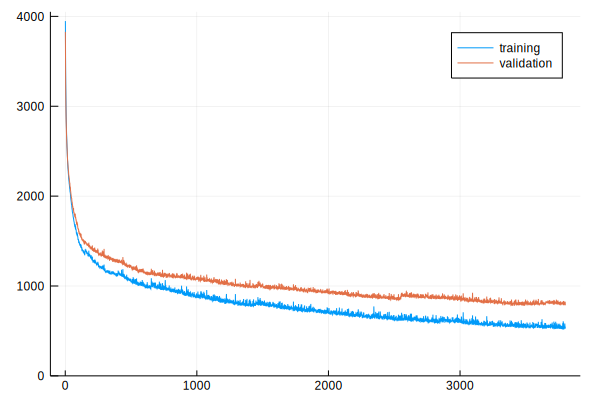

288.947466 seconds (635.02 M allocations: 36.101 GiB, 6.36% gc time)


Progress:  76%|███████████████████████████████          |  ETA: 2:19:51

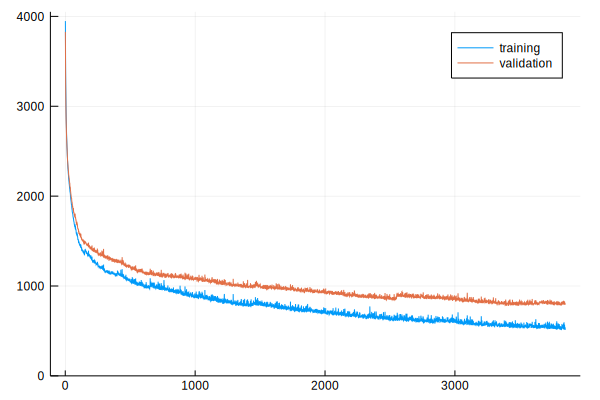

284.516382 seconds (638.57 M allocations: 36.303 GiB, 6.44% gc time)


Progress:  77%|████████████████████████████████         |  ETA: 2:14:19

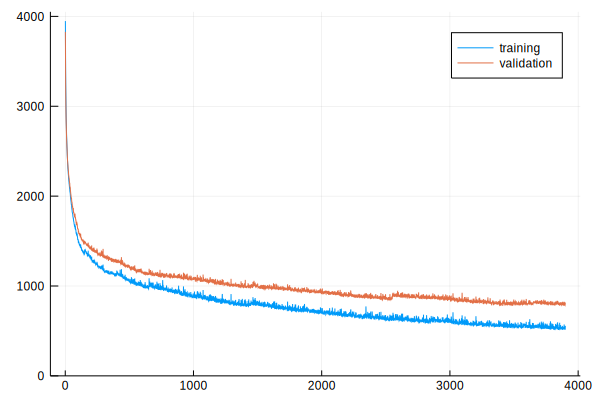

305.710559 seconds (642.13 M allocations: 36.505 GiB, 6.06% gc time)


Progress:  78%|████████████████████████████████         |  ETA: 2:08:39

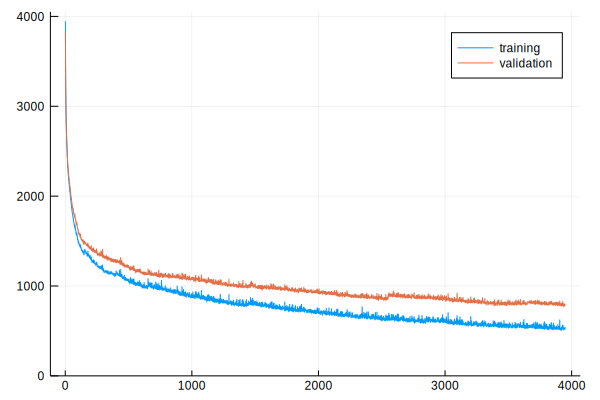

272.902402 seconds (645.68 M allocations: 36.707 GiB, 6.44% gc time)


Progress:  79%|████████████████████████████████         |  ETA: 2:02:40

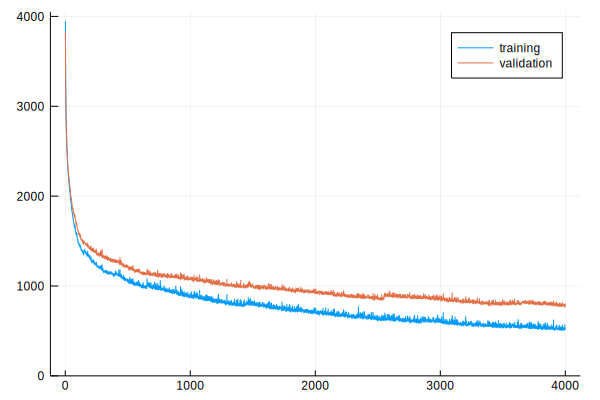

398.651994 seconds (649.24 M allocations: 36.910 GiB, 5.44% gc time)


Progress:  80%|█████████████████████████████████        |  ETA: 1:57:13

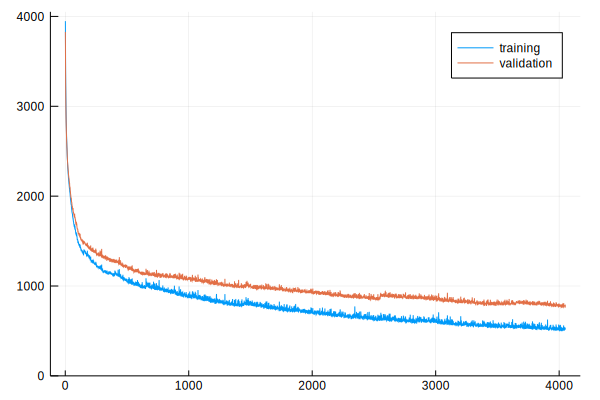

275.800172 seconds (652.79 M allocations: 37.112 GiB, 6.71% gc time)


Progress:  81%|█████████████████████████████████        |  ETA: 1:51:46

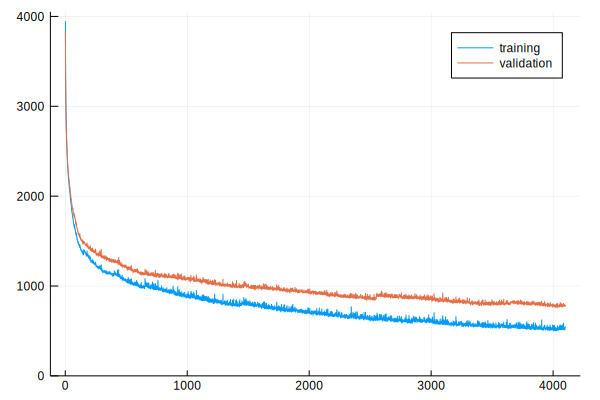

346.463310 seconds (655.73 M allocations: 37.279 GiB, 5.45% gc time)


Progress:  82%|██████████████████████████████████       |  ETA: 1:46:13

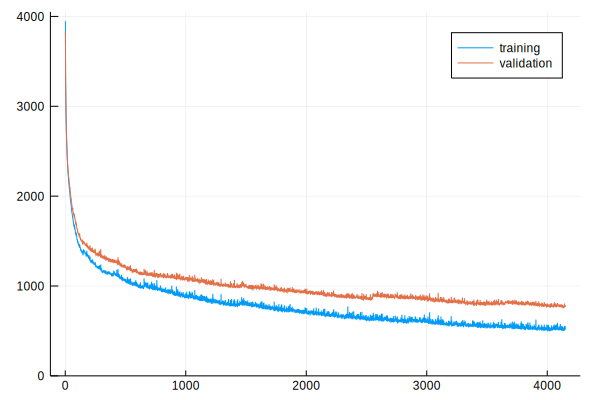

258.424704 seconds (659.29 M allocations: 37.481 GiB, 6.80% gc time)


Progress:  83%|██████████████████████████████████       |  ETA: 1:40:10

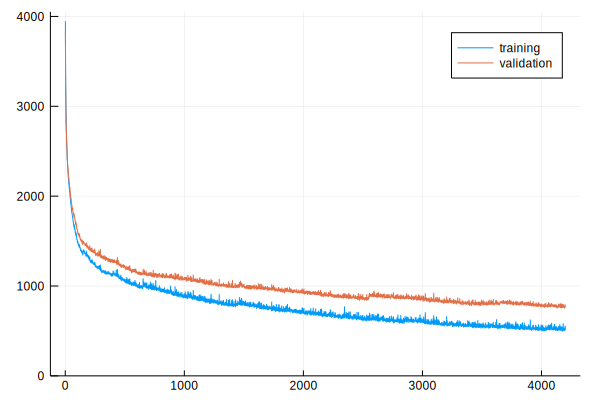

308.203367 seconds (662.84 M allocations: 37.683 GiB, 5.95% gc time)


Progress:  84%|██████████████████████████████████       |  ETA: 1:34:17

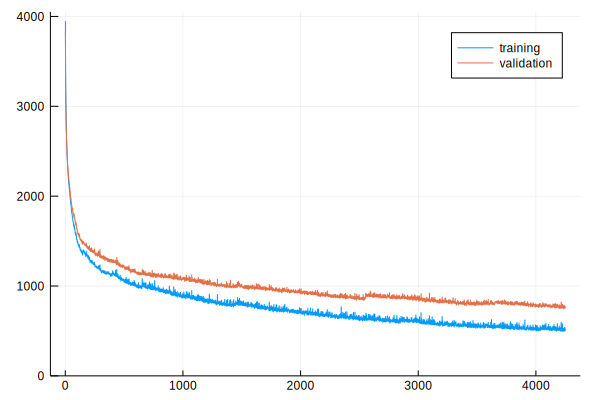

309.249783 seconds (666.40 M allocations: 37.885 GiB, 6.30% gc time)


Progress:  85%|███████████████████████████████████      |  ETA: 1:28:24

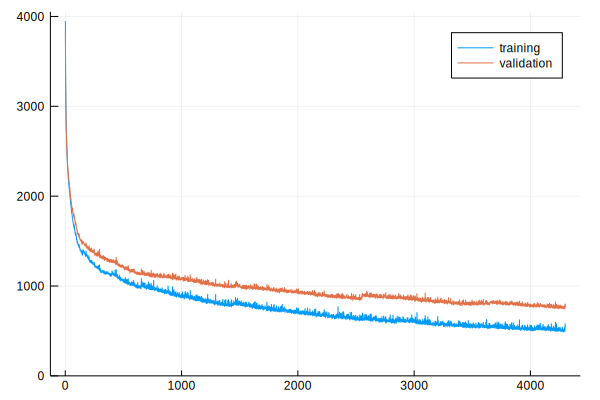

321.099064 seconds (669.95 M allocations: 38.087 GiB, 5.99% gc time)


Progress:  86%|███████████████████████████████████      |  ETA: 1:22:40

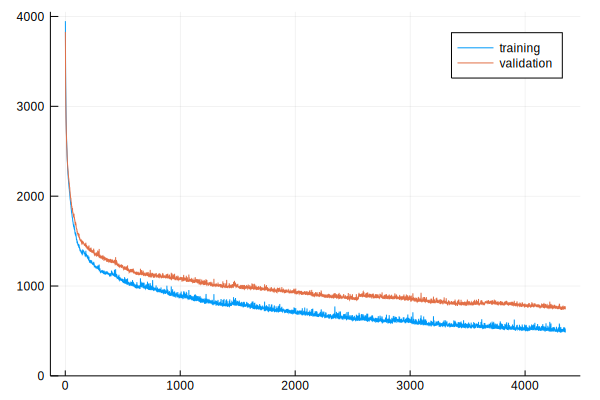

267.712622 seconds (673.51 M allocations: 38.289 GiB, 6.93% gc time)


Progress:  87%|████████████████████████████████████     |  ETA: 1:16:40

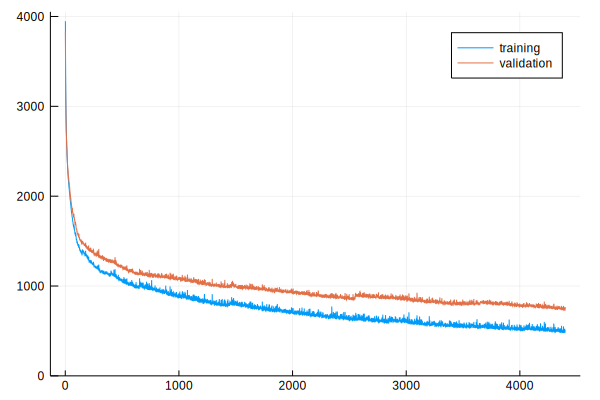

307.294713 seconds (677.06 M allocations: 38.491 GiB, 6.42% gc time)


Progress:  88%|████████████████████████████████████     |  ETA: 1:10:47

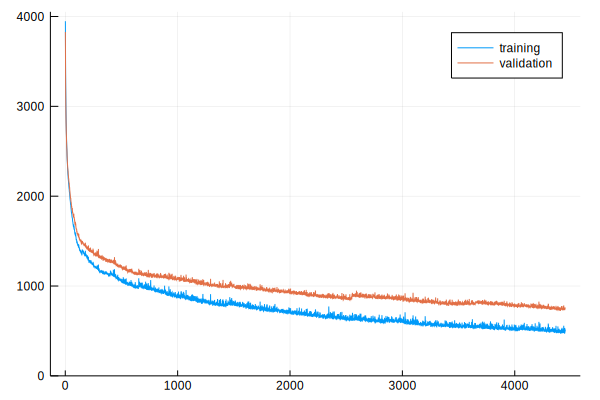

324.837547 seconds (680.62 M allocations: 38.694 GiB, 6.23% gc time)


Progress:  89%|████████████████████████████████████     |  ETA: 1:04:55

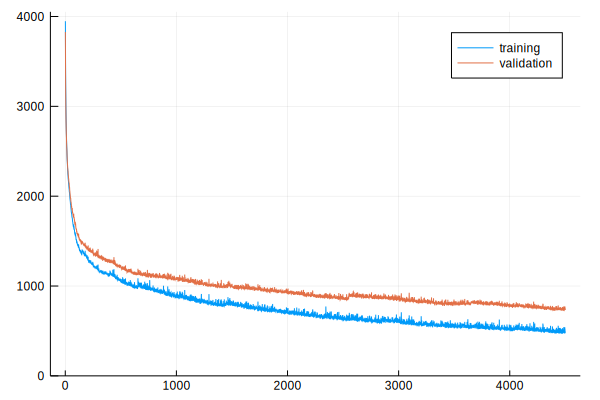

272.308642 seconds (684.17 M allocations: 38.896 GiB, 6.89% gc time)


Progress:  90%|█████████████████████████████████████    |  ETA: 0:59:09

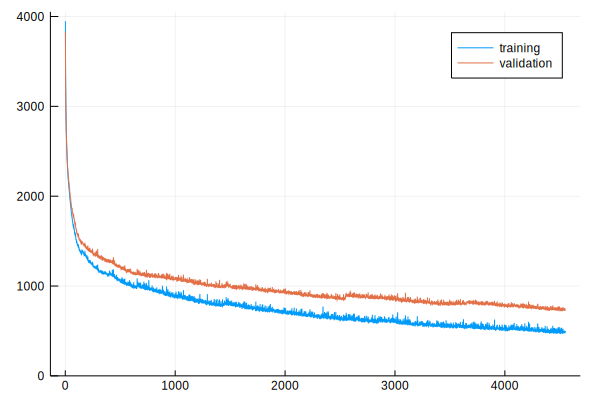

363.970608 seconds (687.73 M allocations: 39.098 GiB, 6.01% gc time)


Progress:  91%|█████████████████████████████████████    |  ETA: 0:53:20

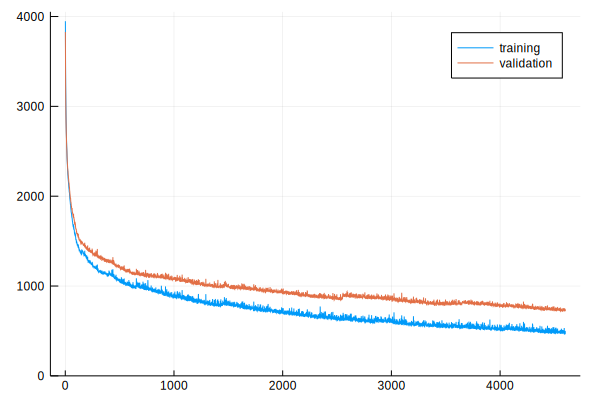

276.872083 seconds (691.28 M allocations: 39.300 GiB, 6.91% gc time)


Progress:  92%|██████████████████████████████████████   |  ETA: 0:47:31

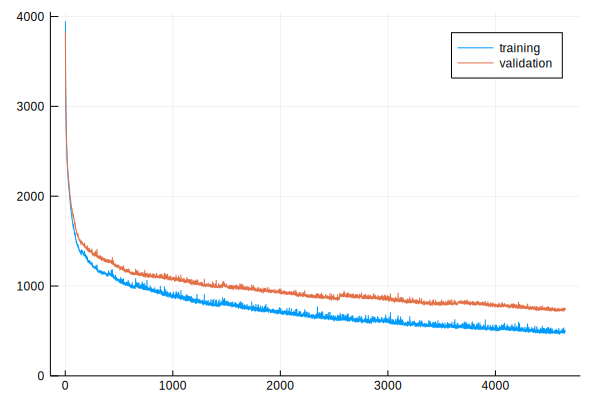

312.191409 seconds (691.60 M allocations: 39.318 GiB, 6.20% gc time)


Progress:  93%|██████████████████████████████████████   |  ETA: 0:41:34

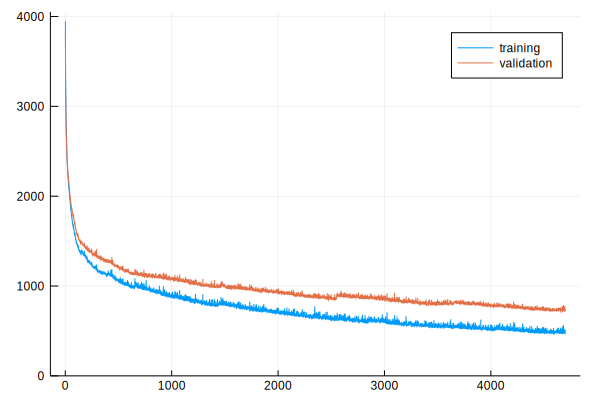

322.531425 seconds (695.15 M allocations: 39.520 GiB, 6.23% gc time)


Progress:  94%|███████████████████████████████████████  |  ETA: 0:35:38

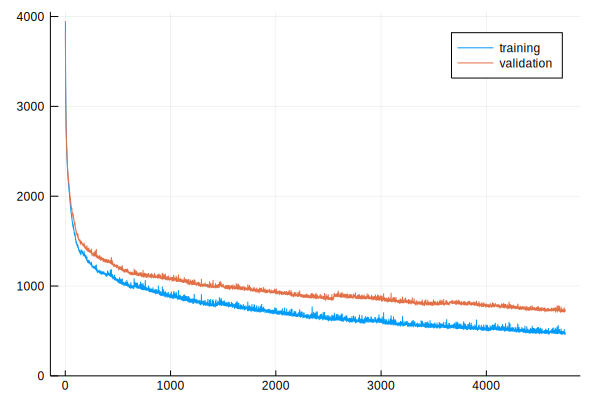

287.655478 seconds (698.71 M allocations: 39.722 GiB, 6.65% gc time)


Progress:  95%|███████████████████████████████████████  |  ETA: 0:29:41

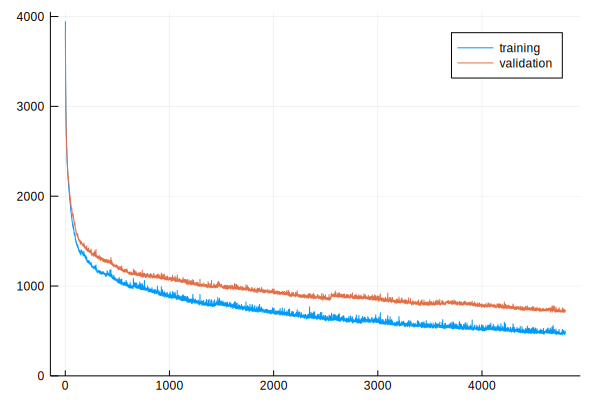

336.928026 seconds (702.26 M allocations: 39.924 GiB, 5.84% gc time)


Progress:  96%|███████████████████████████████████████  |  ETA: 0:23:46

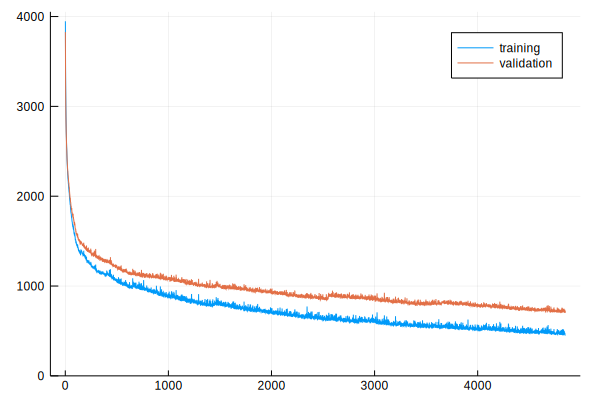

354.088449 seconds (705.82 M allocations: 40.126 GiB, 6.03% gc time)


Progress:  97%|████████████████████████████████████████ |  ETA: 0:17:52

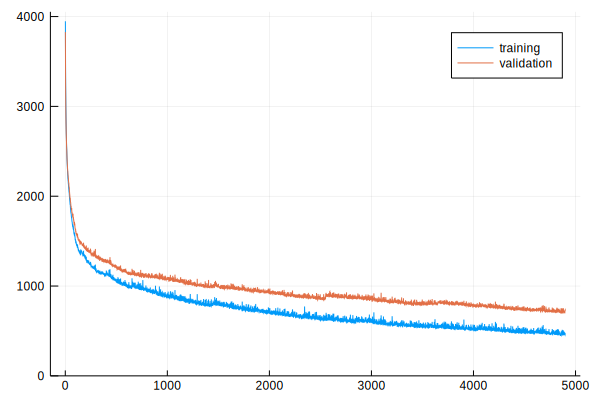

352.580024 seconds (709.37 M allocations: 40.328 GiB, 6.12% gc time)


Progress:  98%|████████████████████████████████████████ |  ETA: 0:11:55

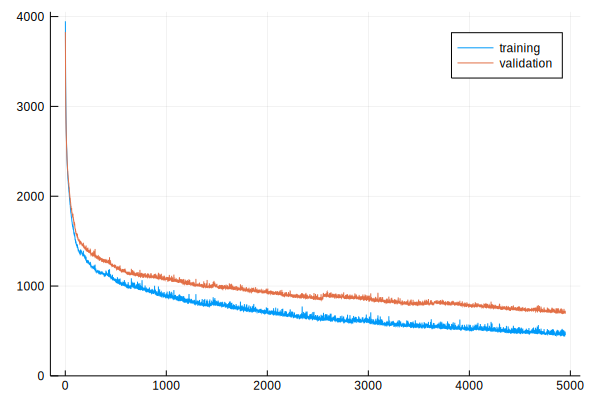

281.459317 seconds (712.93 M allocations: 40.530 GiB, 6.67% gc time)


Progress:  99%|█████████████████████████████████████████|  ETA: 0:05:59

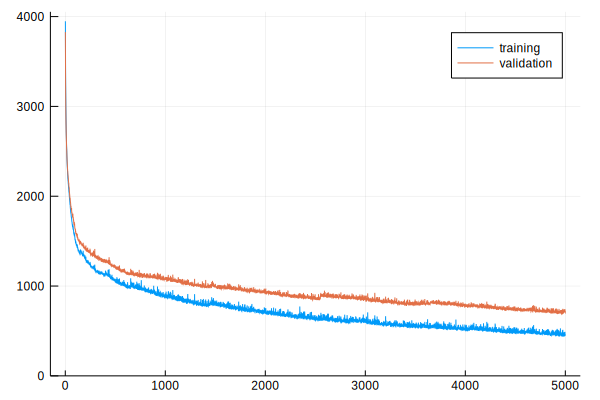

395.478168 seconds (716.48 M allocations: 40.732 GiB, 5.90% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 9:59:14


In [54]:
datasets = Vector{LearningMPC.Dataset{Float64}}()
losses = Vector{Tuple{Float64, Float64}}()

N_iter = 100
σv = 5.0

@showprogress for i in 1:N_iter
    dataset = LearningMPC.Dataset(lqrsol)
    for i in 1:2
        collect_into!(dataset.training_data, σv * i / N_iter)
    end
    
    filter!(dataset.training_data) do sample
        all(isfinite, sample.input)
    end
    
    new_samples = tuple.(dataset.training_data)
    if !isempty(new_samples)
        new_training, new_validation = splitobs(shuffleobs(new_samples); at=0.8)
        append!(all_training_data, new_training)
        append!(all_validation_data, new_validation)
    end

    @time for i in 1:50
        Flux.train!(loss, shuffleobs(all_training_data), optimizer)
        push!(losses, 
            (mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_training_data),
             mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_validation_data)))
    end
    push!(datasets, dataset)
    
    jldopen(dataset_file, "w") do file
        file["datasets"] = datasets
        file["net"] = net
        file["lqrsol"] = lqrsol
        file["mpc_params"] = Dict(
            "Δt" => params.Δt, 
            "horizon" => params.horizon,
        )
        file["losses"] = losses
    end
    
#     jldopen(library_file, "w") do file
#         file["training"] = all_training_data
#         file["testing"] = all_validation_data
#     end
    
    plt = plot(first.(losses), label="training")
    plot!(plt, last.(losses), label="validation")
    ylims!(plt, (0, ylims(plt)[2]))
    display(plt)

end